In [32]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from Thresholding import otsu
from Boundaries import boundaries_detection
from Boundaries import freeman_chain_code
from Borders import border_detection
class Image:
    def __init__(self,data,label,rotated=False,resized=False):
        self.data = data
        self.borderImage = None
        self.label = label
        self.boundary = None
        self.boundaryImage = None
        self.rotated = rotated
        self.resized = resized

    def __str__(self) -> str:
        return f"{self.data}"

    def getBoundaries(self)->None:
        binaryImage = otsu.otsu_image(self.data)
        self.borderImage = border_detection.canny_bordering(binaryImage)
        self.boundaryImage,self.boundary = boundaries_detection.moore_boundary_detection(self.borderImage)

    def getFreemanChain(self):
        if(self.boundary is None):
            self.getBoundaries()
        freemanChainCode = freeman_chain_code.calculate_chain_code(self.boundaryImage)
        self.freemanChainCode = freeman_chain_code.normalize_chain(freemanChainCode)

    def getArea(self):
        rows,columns = self.data.shape
        area = 0
        for r in range(rows):
            for c in range(columns):
                if(self.data[r][c] == 255):
                    area += 1
        return area

    def getPerimeter(self):pass #TODO
    def getCompactness(self):pass #TODO
    def getRectnagularity(self):pass #TODO
    def plotImage(self):
        plt.figure()
        plt.subplot(131)
        plt.imshow(self.data,cmap="gray")
        plt.subplot(132)
        plt.imshow(self.borderImage,cmap="gray")
        plt.subplot(133)
        plt.imshow(self.boundaryImage,cmap="gray")
        plt.show()


## Load data

In [33]:
images = []
imagesRotated = []
imagesResized = []
folder_path = 'images'
init_folders = os.listdir(folder_path)
for folder in init_folders:
    init_folder_path = os.path.join(folder_path, folder)
    cont = 0
    for image_path in os.listdir(init_folder_path):
        if(cont == 10):
            break
        image_folder = os.path.join(init_folder_path,image_path)
        image = cv2.imread(image_folder,cv2.IMREAD_GRAYSCALE)
        imageR = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        imagesRZD = cv2.resize(image,(37,37),interpolation=cv2.INTER_NEAREST)
        images.append(Image(image,folder))
        imagesRotated.append(Image(imageR,folder,rotated=True))
        imagesResized.append(Image(imagesRZD,folder,resized=True))
        cont += 1

[0, 0, 0, 0, 0, 2, 7, 1, 0, 7, 1, 0, 0, 7, 1, 1, 7, 0, 0, 1, 7, 0, 1, 7, 2, 0, 1, 1, 0, 1, 7, 0, 0, 1, 7, 7, 0, 7, 0, 1, 0, 1, 0, 0, 0, 1, 7, 2]


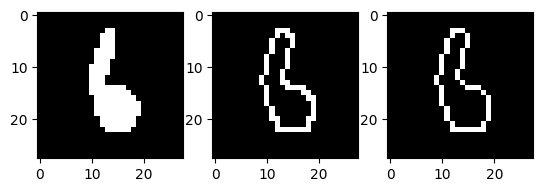

[0, 0, 0, 0, 0, 2, 7, 1, 0, 7, 1, 0, 0, 7, 1, 1, 7, 0, 0, 1, 7, 0, 1, 7, 2, 0, 1, 1, 0, 1, 7, 0, 0, 1, 7, 7, 0, 7, 0, 1, 0, 1, 0, 0, 0, 1, 7, 2]


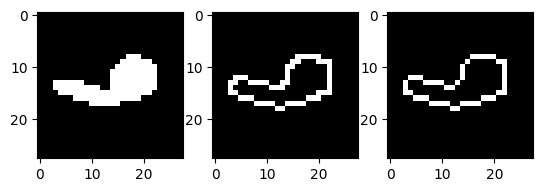

[0, 0, 0, 0, 0, 0, 1, 1, 7, 1, 0, 0, 7, 1, 0, 0, 0, 7, 1, 1, 7, 0, 0, 0, 1, 7, 0, 0, 1, 7, 0, 1, 1, 0, 1, 1, 0, 0, 1, 7, 0, 0, 0, 1, 7, 0, 0, 7, 0, 7, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 7, 1, 1]


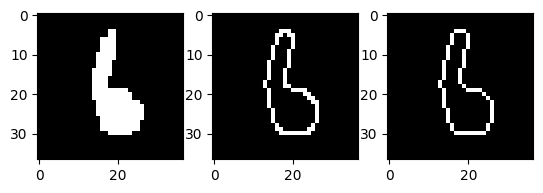

In [34]:
image = images[65]
image.getFreemanChain()
image.plotImage()
image = imagesRotated[65]
image.getFreemanChain()
image.plotImage()
image = imagesResized[65]
image.getFreemanChain()
image.plotImage()